# Brain Tumor Classification

# Objective
The primary goal of this project is to develop a deep learning model to automatically detect and classify brain tumors from MRI images.

Manual analysis of MRI images is challenging and error-prone, especially given the complexity of brain tumor variations. By automating this process, the model can:
- Assist radiologists and neurosurgeons by providing a second opinion.
- Reduce diagnosis time, which is critical in managing aggressive brain tumors.
- Improve diagnostic accuracy, thereby aiding in timely treatment planning.
- Offer an invaluable tool in developing countries where expert medical professionals may be limited.

This approach not only enhances the efficiency of the diagnostic process but also has the potential to save lives by supporting early detection and treatment decisions.

In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from collections import defaultdict
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Dense, Flatten
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

2025-04-11 18:18:41.727727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset
The dataset consists of MRI images used for brain tumor detection and classification available in Kaggle (https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri/data).

The dataset primarily comprises MRI images, each labeled according to the type of brain tumor they represent. The data is organized into a 'Training' and a 'Testing' directory with subdirectories corresponding to various tumor classes or no tumor.

<b>Attributes<b>
- Image data: High-resolution MRI images.
- Labels: Each image is tagged with a tumor classification (glioma, meningioma, pituitary, and no tumor).

# Data Exploration

Classes found: ['no_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']
Class 'no_tumor' has 500 images in total.
Class 'meningioma_tumor' has 937 images in total.
Class 'glioma_tumor' has 926 images in total.
Class 'pituitary_tumor' has 901 images in total.


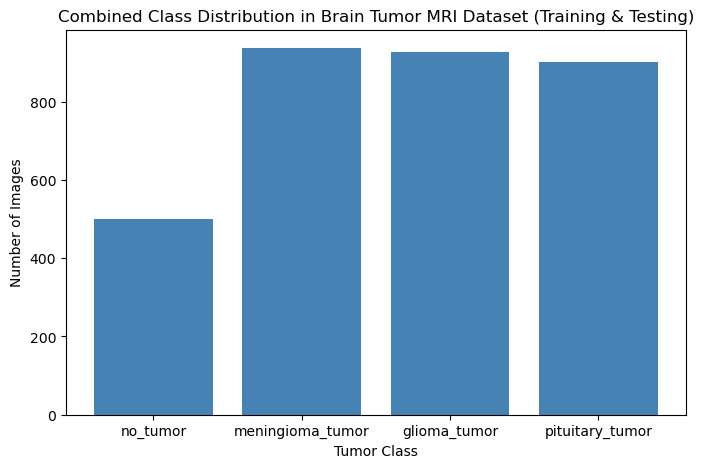

In [2]:
# Set the dataset directory (ensure the folder is in your working directory)
training_dir = "data/Training/"
testing_dir = "data/Testing/"

# List class folders from both training and testing directories and combine them
classes_train = [d for d in os.listdir(training_dir) if os.path.isdir(os.path.join(training_dir, d))]
classes_test = [d for d in os.listdir(testing_dir) if os.path.isdir(os.path.join(testing_dir, d))]
classes = list(set(classes_train).union(set(classes_test)))
print("Classes found:", classes)

# Initialize dictionary to store image counts per class
class_counts = defaultdict(int)

# Loop through each class folder and count images in both training and testing directories
for cls in classes:
    count = 0
    
    # Check and count images in the training directory for the class
    training_class_path = os.path.join(training_dir, cls)
    if os.path.isdir(training_class_path):
        image_files_train = [f for f in os.listdir(training_class_path) 
                             if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        count += len(image_files_train)
    
    # Check and count images in the testing directory for the class
    testing_class_path = os.path.join(testing_dir, cls)
    if os.path.isdir(testing_class_path):
        image_files_test = [f for f in os.listdir(testing_class_path) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        count += len(image_files_test)
    
    # Save the total count for the class
    class_counts[cls] = count
    print(f"Class '{cls}' has {count} images in total.")

# Visualize the combined class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='steelblue')
plt.title("Combined Class Distribution in Brain Tumor MRI Dataset (Training & Testing)")
plt.xlabel("Tumor Class")
plt.ylabel("Number of Images")
plt.show()

- Class distribution: Well balanced among the tumor types.

# Data Preprocessing

- Standardization of images: All images are preprocessed following the VGG16 model preprocessing steps (used later in our modeling), so our data is standarized in the same way the data the model we use was trained on.
- Encoding categorical lables: Categorical lables are transformed into numerical variables and then one-hot encoded.

In [3]:
# Lists to store images and corresponding labels
X_train = []
y_train = []
X_test = []
y_test = []

# We will also store the raw images (before preprocessing) for display purposes.
X_train_raw = []
X_test_raw = []

# List of class labels
labels = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']

# Desired width and height for the images
image_size = 224

# Process training data
for label in labels:
    folderPath = os.path.join(training_dir, label)
    for file_name in os.listdir(folderPath):
        img_path = os.path.join(folderPath, file_name)
        img = cv2.imread(img_path)
        if img is not None:
            # Resize to desired dimensions
            img = cv2.resize(img, (image_size, image_size))
            # Convert BGR (OpenCV default) to RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Store the raw image (for display)
            X_train_raw.append(img_rgb)
            # Preprocess the image as expected by VGG16 (this converts RGB to BGR and subtracts the per-channel means)
            img_preprocessed = tf.keras.applications.vgg16.preprocess_input(img_rgb)
            X_train.append(img_preprocessed)
            y_train.append(label)
        else:
            print(f"Warning: Could not load image {img_path}")

# Process testing data
for label in labels:
    folderPath = os.path.join(testing_dir, label)
    for file_name in os.listdir(folderPath):
        img_path = os.path.join(folderPath, file_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X_test_raw.append(img_rgb)
            img_preprocessed = tf.keras.applications.vgg16.preprocess_input(img_rgb)
            X_test.append(img_preprocessed)
            y_test.append(label)
        else:
            print(f"Warning: Could not load image {img_path}")

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train_raw = np.array(X_train_raw)
X_test_raw = np.array(X_test_raw)

# Shuffle images
X_train, y_train = shuffle(X_train, y_train, random_state=26)
X_test, y_test = shuffle(X_test, y_test, random_state=26)
X_train_raw, _ = shuffle(X_train_raw, y_train, random_state=26) # Ensuring raw images maintain the same order

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2870, 224, 224, 3)
y_train shape: (2870,)
X_test shape: (394, 224, 224, 3)
y_test shape: (394,)


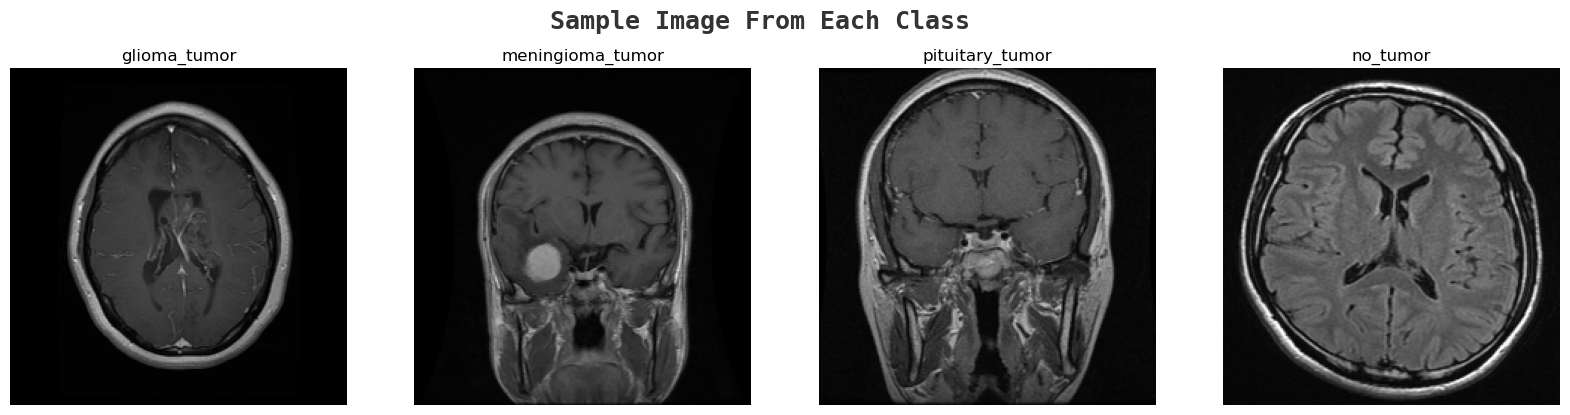

In [4]:
# Sample images
k = 0
fig, ax = plt.subplots(1, len(labels), figsize=(20, 5))
fig.suptitle("Sample Image From Each Class", size=18, fontweight='bold', fontname='monospace', color='black', y=0.95, alpha=0.8)

# For each label, loop through y_train to find the first occurrence and display the corresponding raw image
for label in labels:
    j = 0
    while j < len(y_train):
        if y_train[j] == label:
            # Use the raw image for display (from X_train_raw)
            ax[k].imshow(X_train_raw[j])
            ax[k].set_title(label)
            ax[k].axis('off')
            k += 1
            break
        j += 1

plt.show()

In [5]:
# Encode categorical labels into numerical labels and perform one-hot encoding on the numerical labels
label_encoder = LabelEncoder()

# Label encoding
y_train = label_encoder.fit_transform(y_train) # Fit on training data and transform training data
y_test = label_encoder.transform(y_test) # Use the same mapping for the test data

# Convert to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Modeling

<b>Transfer Learning Model<b>
- Architecture: Utilizes a pre-trained VGG16 network as the feature extractor with its weights frozen, then adds custom classification layers.
- Purpose: Leverages the robust feature representations learned from large-scale image datasets (e.g., ImageNet) to improve classification performance on MRI images, reducing training time and increasing accuracy.

In [6]:
# Check for GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPU detected. Running on CPU.")

# Set parameters
input_shape = (224, 224, 3)
num_classes = len(labels)
learning_rate = 1e-4

# Load the VGG16 model with pretrained weights, excluding its top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(input_shape))

# Freeze the layers of VGG16 so they are not updated during the initial training stages
for layer in base_model.layers:
    layer.trainable = False

# Use GlobalAveragePooling2D to reduce overfitting
# Use Dense layer and Dropout to learn new features
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduce feature dimensions
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model using categorical crossentropy (for one-hot encoded labels) and Adam optimizer
model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# Define early stopping callback to halt training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train, 
    y_train,
    validation_split=0.15, 
    epochs=15, 
    batch_size=32, 
    callbacks=[early_stopping]
)

No GPU detected. Running on CPU.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D) 

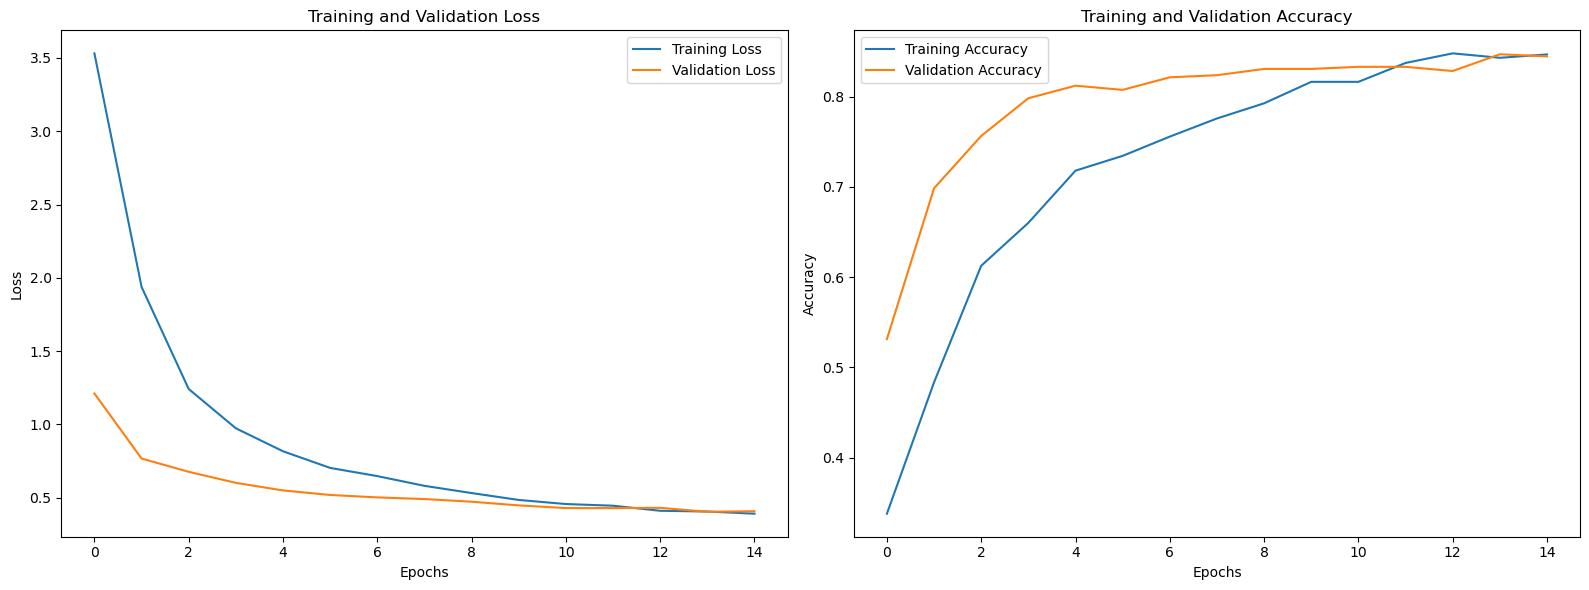

In [7]:
# Training and validation loss and accuracy

plt.figure(figsize=(16, 6))

# Left plot: Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Right plot: Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Test Loss: 1.0989
Test Accuracy: 0.7030
13/13 [==============================] - 63s 5s/step

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.67      0.32      0.43       100
meningioma_tumor       0.62      0.83      0.71       115
 pituitary_tumor       0.71      0.79      0.75       105
        no_tumor       0.87      0.91      0.89        74

        accuracy                           0.70       394
       macro avg       0.72      0.71      0.69       394
    weighted avg       0.70      0.70      0.68       394



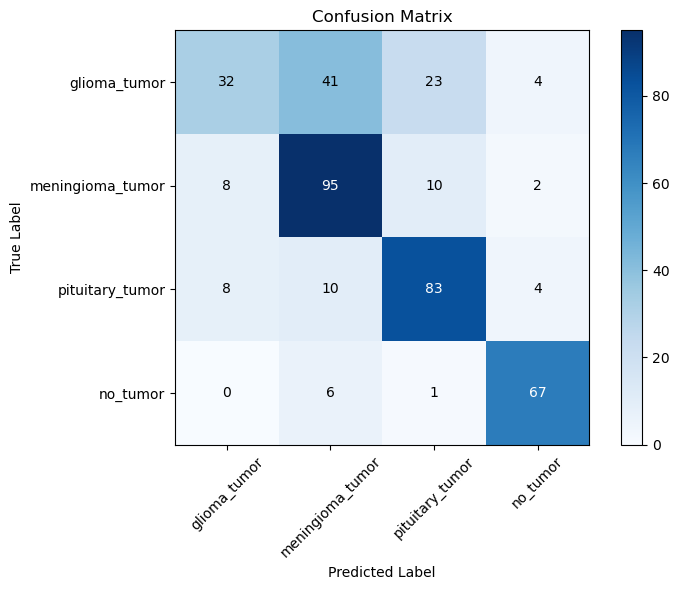

In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) # Convert the probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1) # Convert the ground truth one-hot vectors to class indices

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Add text annotations to each cell
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Conclusion

The test results demonstrate that the model achieves an overall test accuracy of approximately 70%. Notably, the "no_tumor" class is predicted very accurately, with a precision of 0.87, recall of 0.91, and an F1-score of 0.89, indicating robust performance in identifying healthy cases. Similarly, the "pituitary_tumor" and "meningioma_tumor" classes show moderate to high performance, with F1-scores of 0.75 and 0.71, respectively. However, the "glioma_tumor" class presents challenges, as evidenced by a low recall of 0.32 and an F1-score of 0.43, indicating that many glioma cases are being confused with other types of tumor. Overall, while the model performs well for most classes, further improvements are needed to enhance sensitivity and achieve a more balanced performance across all classes.